Copyright (c) 2023 Qualcomm Innovation Center, Inc. All rights reserved. <br>
SPDX-License-Identifier: BSD-3-Clause-Clear

**Takeaways** : Users will learn to profile inferences running large language models (LLMs) on Cloud AI 100 at a device level <br><br>
**Before you start** : Some commands (folder locations etc) will need to be updated based on the platform and installation locations. 'Sudo' prefix might be required for some commands to run properly. <br> This notebook assumes that the user understands how to onboard a model, compile and run using qaic-exec and qaic-runner (AIC native tools) respectively. <br>
The terms 'model' and 'network' are used interchangeably in this notebook. 
The terms 'NSP' and 'AI compute core" are used interchangeably in this notebook. 

**Last Verified Qualcomm Cloud AI Platform SDK and Apps SDK Version:** Platform SDK 1.12.0.88 and Apps SDK 1.12.2.0 

# <span style='color:Blue'> Profiling Inferences </span>

##  Pre-requisite reading 
- Users are expected to have a good understanding of the LLM [model generation workflow](https://github.com/quic/cloud-ai-sdk/tree/1.12/models/language_processing/decoder/LlamaForCausalLM). 
- Users are expected to have a good understanding of the compilation (qaic-exec) and inference (qaic-runner, qaic-api-test) execution tools.
- Users are expected to have a good understanding of the [AI 100 architecture](https://quic.github.io/cloud-ai-sdk-pages/latest/Getting-Started/Architecture/) 

## Introduction 
This notebook will cover inference profiling at device level using the 'LLM360/Amber' model from HuggingFace. 

Here is the workflow that will be demonstrated in this notebook. 

1. **Download the model**: Begin by downloading the model.  
2. **Device health check**: Query the device health using qaic-util tool.
3. **Generate the Model**: Generate the ONNX model with modifications required to run on AI 100 Platforms. 
4. **Device-level profiling** : Generate DDR stats and Opstats (aka execution stats)

# <span style='color:Blue'>1. Download the Model - LLM360/Amber </span>
```
pip install -U "huggingface_hub[cli]"
huggingface-cli download LLM360/Amber
```

# <span style='color:Blue'>2. Check Device Health </span>

'qaic-util' tool can be used to query the health of all the Cloud AI cards in the server. 

"Status: Ready" indicates that the health of the cards is good. 

"Status: Error" indicates that the cards are not in good health and a system administrator needs to be contacted to rectify the issue. 


In [23]:
!/opt/qti-aic/tools/qaic-util -q | grep "Status"

	Status:Ready
	Status:Ready
	Status:Ready
	Status:Ready
	Status:Ready
	Status:Ready
	Status:Ready
	Status:Ready


# <span style='color:Blue'>3. Generate the Model </span>

Follow [Generate the Model](https://github.com/quic/cloud-ai-sdk/tree/1.12/models/language_processing/decoder/LlamaForCausalLM#model-generation) instructions to generate the LLM360/Amber in ONNX format with the changes required to run efficiently on AI 100 platforms. 

Run the rest of the notebook within the same Python venv. 


# <span style='color:Blue'>4. Device level Profiling </span>

[This link](https://quic.github.io/cloud-ai-sdk-pages/latest/Getting-Started/Model-Architecture-Support/Large-Language-Models/llm/#decoder-only-models) describes the execution of decoder models on AI 100 platforms. Execution consists of 2 stages - prefill and decode. We will compile them independently to analyze them. 

For device level inference stats, `-aic-profiling-type=stats -aic-profiling-type=trace -aic-profiling-type=latency` flags are required during the model compilation and Execution. Note that device level profiling (using `-aic-profiling-type=stats -aic-profiling-type=trace`) may slow down the inference execution by a bit due to data collection. This is not a concern for LLMs since data collection is expected to be a very small portion of the inference.  

For DDR stats, `-aic-perf-metrics` is required during compilation. It should not be combined with `-aic-profiling-type=stats and -aic-profiling-type=trace` for DDR memory usage analysis. 


### DDR Stats 
The compile stats with `-aic-perf-metrics` lets us 
- estimate the total DDR memory consumed by the model constants
- estimate the spill to DDR from VTCM

### Execution Stats aka Opstats
The execution stats aka Opstats are quite powerful and lets us 
- analyze HMX, HVX and DMA engine loading (DDR bound vs compute bound)
- device throughput vs system inference performance
- analyze the pcycles(%) used by each operator
- analyze operator performance (VTCM vs DDR)
- analyze operator distribution across cores


In [1]:
# change directory
%cd ../../../models/language_processing/decoder/LlamaForCausalLM

/home/ec2-user/aashwins/cloud-ai-sdk/models/language_processing/decoder/LlamaForCausalLM


We will create the specializations files for compilation (prefill and decode).

In [2]:
%%writefile specialization_decode.json
{
        "specializations": [
                {
                        "batch_size": "1",
                        "seq_len": "32",
                        "ctx_len": "128"
                }
        ]
}

Overwriting specialization_decode.json


In [15]:
%%writefile specialization_prefill.json
{
        "specializations": [
                {
                        "batch_size": "1",
                        "seq_len": "32",
                        "ctx_len": "128"
                }
        ]
}

Writing specialization_prefill.json


## DDR Memory Stat Generation
We will compile the model with the `-aic-perf-metrics` flag. Here, we are showing the prefill stage. 

In [19]:
%%bash
rm -rf qpc
mkdir -p qpc
model_name="Amber-kv"
prompt_len=32
ctx_len=128
num_cores=14
num_blocks=$(grep 'value.' ${model_name}/custom_io.yaml | tail -n1 | grep -Eo '[[:digit:]]+')
model_path=${model_name}/generatedModels/Amber-kv_fp16.onnx
mkdir -p dump-${model_name}-${prompt_len}pl-${ctx_len}cl-${num_cores}c
/opt/qti-aic/exec/qaic-exec \
	-m=$model_path \
	-aic-hw \
	-aic-hw-version=2.0 \
	-network-specialization-config=specialization_prefill.json \
	-retained-state \
	-convert-to-fp16 \
	-aic-num-cores=${num_cores} \
	-custom-IO-list-file=${model_name}/custom_io.yaml \
	-compile-only \
	-aic-binary-dir=qpc/${model_name}-kv-${prompt_len}pl-${ctx_len}cl-${num_cores}c \
	-aic-perf-metrics \
	-aic-perf-warnings 

Reading ONNX Model from Amber-kv/generatedModels/Amber-kv_fp16.onnx
Compile started ............... 
Compiling model with FP16 precision.


/model/Slice: end[0] (65504) larger than number of elements in this dimension. Clamping to dimension size.
/model/layers.0/self_attn/Slice_1: end[3] (65504) larger than number of elements in this dimension. Clamping to dimension size.
/model/layers.0/self_attn/Slice_3: end[3] (65504) larger than number of elements in this dimension. Clamping to dimension size.
/model/layers.0/self_attn/Slice_4: end[0] (65504) larger than number of elements in this dimension. Clamping to dimension size.
/model/layers.0/self_attn/Slice_5: end[0] (65504) larger than number of elements in this dimension. Clamping to dimension size.
/model/layers.1/self_attn/Slice_1: end[3] (65504) larger than number of elements in this dimension. Clamping to dimension size.
/model/layers.1/self_attn/Slice_3: end[3] (65504) larger than number of elements in this dimension. Clamping to dimension size.
/model/layers.1/self_attn/Slice_4: end[0] (65504) larger than number of elements in this dimension. Clamping to dimension siz

AIC WARNING: MAC estimate does not yet handle all operations
Original MAC estimate: 208,436,985,856
Original Graph operation size histogram:
     output elts      op count (cumulative)
               1                    5    0%
               2                    8    0%
              32                  341   14%
             128                  343   14%
           1,024                  347   15%
           3,072                  350   15%
           4,096                  368   15%
          32,000                  370   16%
          65,536                  562   24%
         131,072                2,014   87%
         352,256                2,142   93%
         524,288                2,302  100%
preD32 constants size: 12876 MB
AIC HMX MAC estimate: 212,500,217,856
AIC non-HMX MAC estimate: 0
d32 constants size: 12857 MB
final constants size: 12857 MB
final combined specializations constants size:	12852 MB
VTCM0Size:	8162 KB
VTCM1Size:	8141 KB
VTCM2Size:	7937 KB
VTCM3Size:	7957 

## DDR Stats Explained
#### Estimate the total DDR memory consumed by the model constants (primarily weights)
```
constants.bin QPC section size: 12868 MB
```
This tells us that the model constants (primarily weights) use up 12.8GB of the DDR memory. The Standard SKU (14 NSPs) has 16GB of onboard DDR memory. The remaining memory holds the KV cache, intermediate activations, LUTs etc.

#### Estimate the spill to DDR from VTCM
```
  total: DDR traffic  read:   13019511 KB (first-inf   13041956 KB)
             constant only:   12888376 KB (first-inf   12910821 KB)
  total: DDR traffic write:     131135 
````

The difference between the `DDR traffic read` and `constant only` provides an estimate of the spill to DDR memory. 'Spill' refers to data (not constants but activations etc) being written (and read later) to DDR because VTCM is full. In this example, its seen atth 131MB of data is spilled to the DDR. A very large 'spill' valuwill e leds to lower performanc In the prefill case, users can expect the `DDR traffic write` to be equal to the difference between `DDR traffic read` and `constant only`. In the decode case, the `DDR traffic write` will **not** be equal to the difference between `DDR traffic read` and `constant only.`


## Execution stats aka OpStats Generation
Generating opstats requires the model to be compiled and executed with `-aic-profiling-type=stats -aic-profiling-type=trace` flags. On execution, a json trace file and a text file (eg. aic-profiling-program-0-activation-0-inf-5.txt) is generated. 
We will focus on decode portion of the inference in this case. 

The trace file can be quite large (100s of MB). So `--aic-profiling-num-samples` should be set either `1` or `2`.  

In [21]:
%%bash
rm -rf qpc
mkdir -p qpc
model_name="Amber-kv"
prompt_len=1
ctx_len=128
num_cores=14
num_blocks=$(grep 'value.' ${model_name}/custom_io.yaml | tail -n1 | grep -Eo '[[:digit:]]+')
model_path=${model_name}/generatedModels/Amber-kv_fp16.onnx
mkdir -p dump-${model_name}-${prompt_len}pl-${ctx_len}cl-${num_cores}c
/opt/qti-aic/exec/qaic-exec \
	-m=$model_path \
	-aic-hw \
	-aic-hw-version=2.0 \
	-network-specialization-config=specialization_decode.json \
	-retained-state \
	-convert-to-fp16 \
	-aic-num-cores=${num_cores} \
	-custom-IO-list-file=${model_name}/custom_io.yaml \
	-compile-only \
	-aic-binary-dir=qpc/${model_name}-kv-${prompt_len}pl-${ctx_len}cl-${num_cores}c \
	-aic-perf-metrics \
	-aic-perf-warnings \
	-aic-profiling-type=stats -aic-profiling-type=trace -aic-profiling-type=latency -v

Reading ONNX Model from Amber-kv/generatedModels/Amber-kv_fp16.onnx
Compile started ............... 
Compiling model with FP16 precision.


/model/Slice: end[0] (65504) larger than number of elements in this dimension. Clamping to dimension size.
/model/layers.0/self_attn/Slice_1: end[3] (65504) larger than number of elements in this dimension. Clamping to dimension size.
/model/layers.0/self_attn/Slice_3: end[3] (65504) larger than number of elements in this dimension. Clamping to dimension size.
/model/layers.0/self_attn/Slice_4: end[0] (65504) larger than number of elements in this dimension. Clamping to dimension size.
/model/layers.0/self_attn/Slice_5: end[0] (65504) larger than number of elements in this dimension. Clamping to dimension size.
/model/layers.1/self_attn/Slice_1: end[3] (65504) larger than number of elements in this dimension. Clamping to dimension size.
/model/layers.1/self_attn/Slice_3: end[3] (65504) larger than number of elements in this dimension. Clamping to dimension size.
/model/layers.1/self_attn/Slice_4: end[0] (65504) larger than number of elements in this dimension. Clamping to dimension siz

AIC WARNING: MAC estimate does not yet handle all operations
Original MAC estimate: 6,640,631,808
Original Graph operation size histogram:
     output elts      op count (cumulative)
               1                  335   14%
               2                  338   14%
              32                  342   14%
              96                  345   15%
             128                  361   15%
           2,048                  681   29%
           4,096                2,006   87%
          11,008                2,134   92%
          32,000                2,136   93%
         524,288                2,296  100%
preD32 constants size: 12852 MB
AIC HMX MAC estimate: 212,500,217,856
AIC non-HMX MAC estimate: 0
d32 constants size: 12858 MB
final constants size: 12858 MB
final combined specializations constants size:	12852 MB
VTCM0Size:	8183 KB
VTCM1Size:	8145 KB
VTCM2Size:	7985 KB
VTCM3Size:	8153 KB
VTCM4Size:	8077 KB
VTCM5Size:	8077 KB
VTCM6Size:	8085 KB
VTCM7Size:	8077 KB
VTCM8Size:	

In [22]:
%%bash
rm -rf opstats_decode
mkdir -p opstats_decode
model_name="Amber-kv"
prompt_len=1
ctx_len=128
num_cores=14
/opt/qti-aic/exec/qaic-runner -t qpc/${model_name}-kv-${prompt_len}pl-${ctx_len}cl-${num_cores}c \
    -S 1 -n 10 -d 0 --write-output-dir=./opstats_decode \
    --aic-profiling-out-dir=./opstats_decode \
    --aic-profiling-type=trace --aic-profiling-type=stats --aic-profiling-type latency\
    --aic-profiling-start-iter 5 --aic-profiling-num-samples 1

Using bounded random inputs
Writing file:./opstats_decode/attention_mask_RetainedState-activation-0-inf-0.bin
Writing file:./opstats_decode/past_key.0_RetainedState-activation-0-inf-0.bin
Writing file:./opstats_decode/past_value.0_RetainedState-activation-0-inf-0.bin
Writing file:./opstats_decode/past_value.1_RetainedState-activation-0-inf-0.bin
Writing file:./opstats_decode/past_key.1_RetainedState-activation-0-inf-0.bin
Writing file:./opstats_decode/past_value.2_RetainedState-activation-0-inf-0.bin
Writing file:./opstats_decode/past_key.2_RetainedState-activation-0-inf-0.bin
Writing file:./opstats_decode/past_value.3_RetainedState-activation-0-inf-0.bin
Writing file:./opstats_decode/past_key.3_RetainedState-activation-0-inf-0.bin
Writing file:./opstats_decode/past_value.4_RetainedState-activation-0-inf-0.bin
Writing file:./opstats_decode/past_key.4_RetainedState-activation-0-inf-0.bin
Writing file:./opstats_decode/past_value.5_RetainedState-activation-0-inf-0.bin
Writing file:./opsta

## Execution Stats aka Opstats Explained 
We will analyze the Opstats file `aic-profiling-program-0-activation-0-inf-5.txt`. 

#### Analyze HMX, HVX and DMA engine loading (DDR bound vs compute bound)
For every core, the utilization of the different HW engines (4 x HVX, 1 x HMX and 1 x DMA) within each core is provided. The utilization can provide a clue to the user if the inference is compute or memory bound. Users should **ignore** the `DMAIssue` utilization as it only captures the start of DMA but does not cnsider the entire length of the DMA transaction. Low HMX or HVX utilization indicates that the inference probably is memory bound. The user can increase the batch size for better performance. For LLMs, prefill is typically compute bound and decode is memory bound. 

```
c9    t0 HVX              2392958 ucycles [3380167107636, 3380169500594]       180714620 pcycles   1.09% utilization
c9    t1 HVX              2392957 ucycles [3380167107637, 3380169500594]       180714604 pcycles   0.99% utilization
c9    t2 HVX              2392957 ucycles [3380167107637, 3380169500594]       180714581 pcycles   0.98% utilization
c9    t3 HVX              2392957 ucycles [3380167107637, 3380169500594]       180714552 pcycles   0.99% utilization
c9    t4 HMX              2392947 ucycles [3380167107637, 3380169500584]       180713856 pcycles   3.85% utilization
c9    t5 DMAIssue         2393326 ucycles [3380167107637, 3380169500963]       180742446 pcycles   5.10% utilization
```

#### Device throughput vs system inference performance
```
[QAicGraph] Device instance batch/s: (1/0.125106): 7.99324
[QAicGraph] Device instance inf/s: (1/0.125106): 7.99324
```
User should compare the device level throughput and the [system level throughput](https://github.com/quic/cloud-ai-sdk/tree/1.12/models/language_processing/decoder/LlamaForCausalLM#model-execution). The 2 values should be close to each other with system level throughput slightly lower than device level. If the 2 values are off by a wide margin, user should analyze the host side application. 

#### Analyze the pcycles(%) used by each operator
The `pcycles(%)` and `count` columns provide the percentage of the processor clock cycles (HMX or HVX or DMA) used by the operator. Say the `pcycles` used by a certain operator is 40%, then optimization of this operator in the compiler or custom operator (user written) will significantly improve the inference throughput and latency. 

#### Analyze operator performance (VTCM vs DDR)
The Opstats file provides details regarding every operator/kernel in the `opdetails` column for every AI core. 

`aicconvolutiond32 HMX TCM (float16, i8, index32)` : The convolution operator runs in the HMX (matrix aka tensor unit) and the inputs are from TCM (of the AI core). This provides the best performance for this operation. If this operation runs on HVX or gets data from DDR, the performance would not be nearly as good. 
Certain operators will operate on the DDR (for example: aiccopytovtcm DMAIssue DDR) and those are expected.   

#### Aanalyze operator distribution across core
The compiler will typically balance the operations and count across all the cores. Say, a certain operator only runs on one core and has a high `count` value. It can be optimized by the compiler to improve performance. Users can share these scenarios with Qualcomm to further optimize the compiler. 

## Execution Trace Explained 
A trace json file is also created which provides a timeline execution of the inference across **all HW engines across all cores**. Users are expected to analyze the Opstats before looking into the trace file. analyzing the trace also requires a good understanding of the HW/SW architecture. 

`aic-profiling-program-0-trace.json` can be loaded in the Chrome browser using `https://ui.perfetto.dev/`. Load the json file. The json file can be quite large (100s of MB). The different HW engines are marked corresponding to the Thread #. 

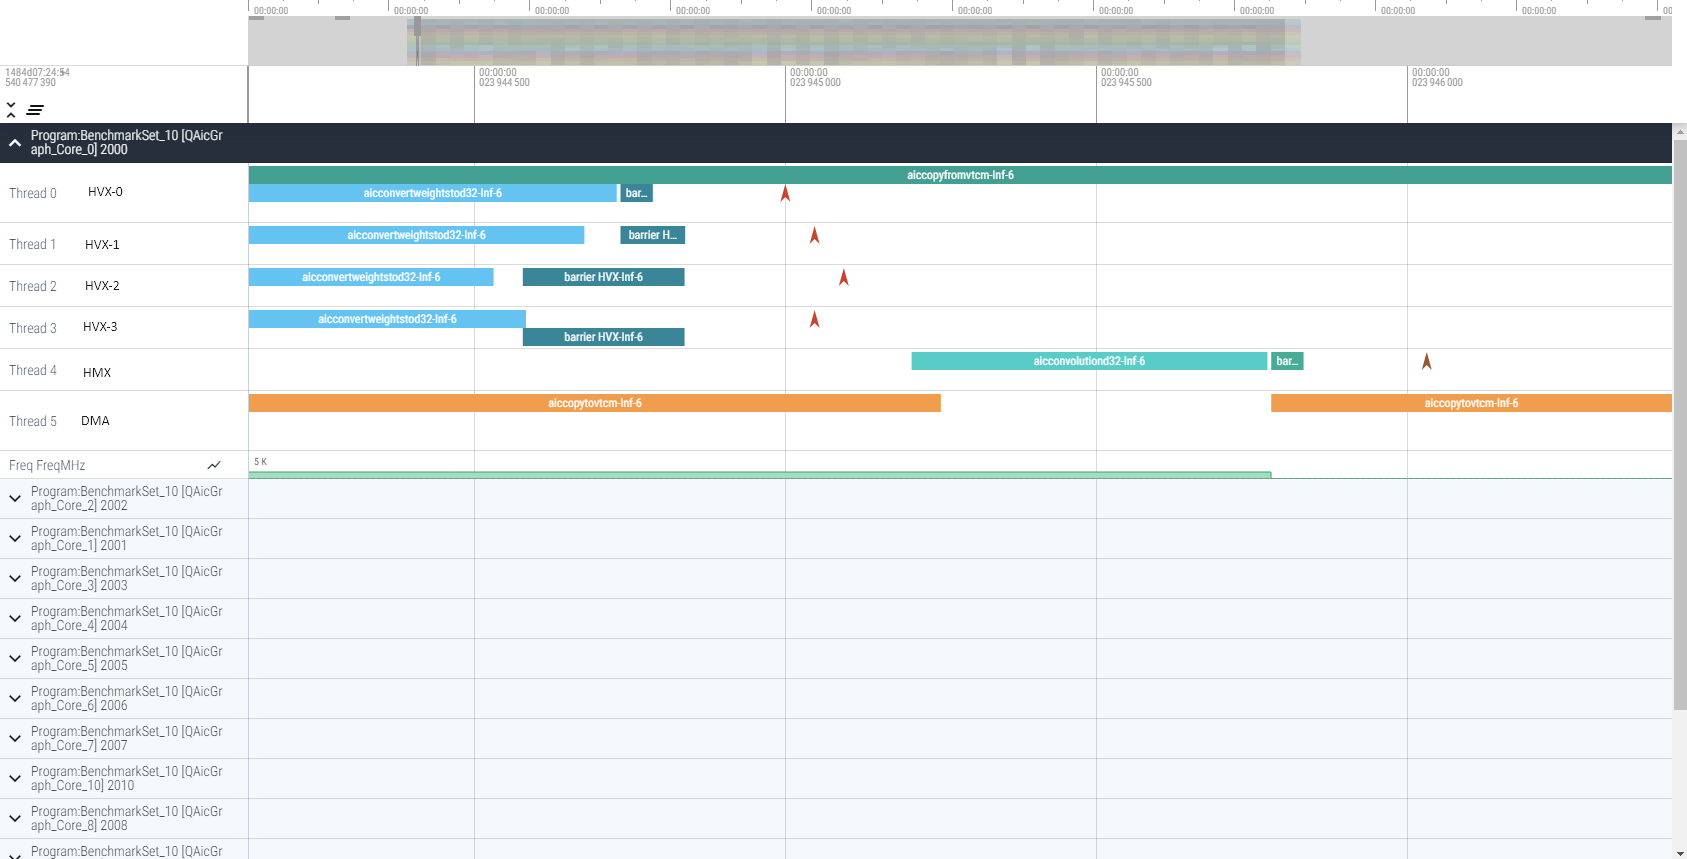




Clicking on the operations provide detailed information regarding the opOperands, opMemory etc. 
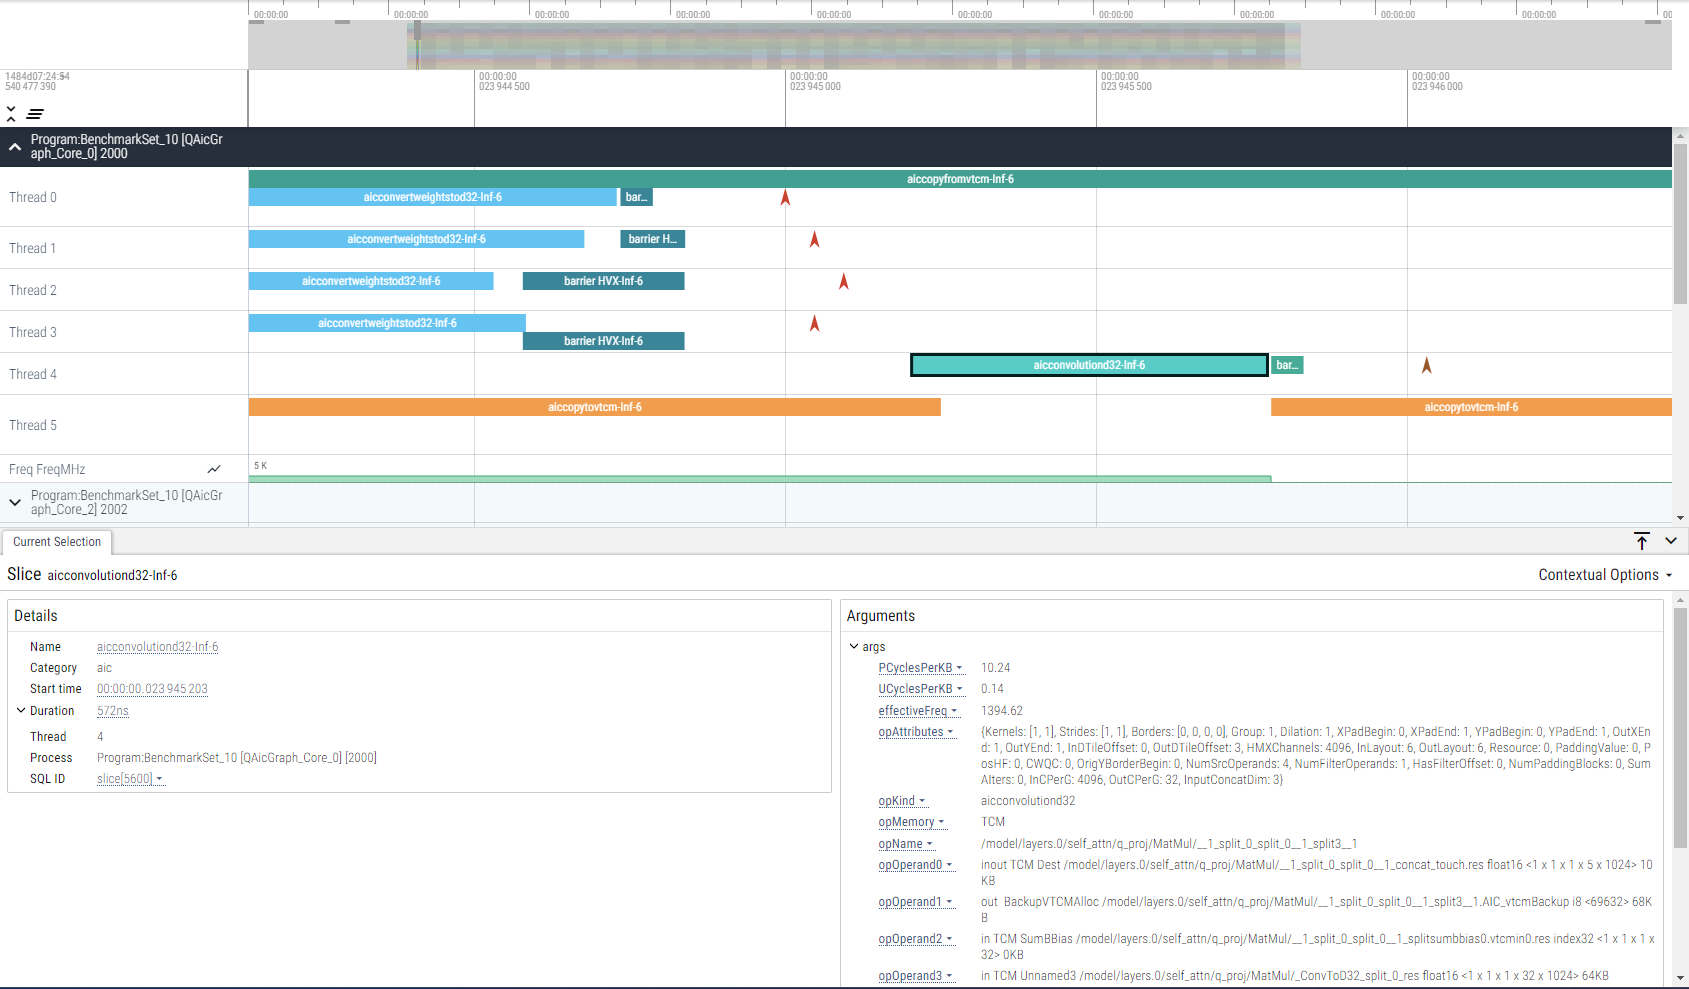

